| Studierende:    | Achim Duong | Lukas Grüßinger | Ferdinand Schuh | Ben Dondelinger|
| --------- | ------------- | ------------- | ------------- | ------------- |


In der Dispositionsabteilung eines Online-Lebensmittel-Lieferdienstes ist ein tiefes Verständnis des Trinkgeldverhaltens von zentraler Bedeutung. Trinkgeld hat nicht nur Auswirkungen auf die Zufriedenheit der Zusteller, sondern kann auch wichtige Einblicke in das Kundenerlebnis und regionale Unterschiede liefern. Unsere Aufgabe als Data Scientists ist es, dieses Verhalten datenbasiert zu analysieren und Maßnahmen abzuleiten, die die Zufriedenheit aller Beteiligten fördern.

Durch diese Analysen kann die Dispositionsabteilung gezielte Maßnahmen ergreifen, um das Trinkgeldverhalten positiv zu beeinflussen, die Motivation der Zusteller zu steigern und gleichzeitig das Kundenerlebnis zu verbessern. Damit leisten wir einen entscheidenden Beitrag zu einem nachhaltig erfolgreichen Betrieb.

# Start | Bibliotheken und Dateien einlesen
---

Gleich aufgebaut wie bei der Analyse für die Marketing-Abteilung werden am Anfang die Daten eingelesen, sowie auch verwendete Bibliotheken am Anfang des Notebooks erfasst.

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
# from ydata_profiling import ProfileReport
import plotly_express as px
from itertools import combinations
from collections import Counter
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
zip_path1 = "../public/aisles.csv.zip"
zip_path2 = "../public/departments.csv.zip"
zip_path3 = "../public/order_products_s.csv.zip"
zip_path4 = "../public/orders_s.csv.zip"
zip_path5 = "../public/products.csv.zip"
zip_path6 = "../public/tips.csv.zip"

df_aisles = pd.read_csv(zip_path1, compression="zip")
df_departments = pd.read_csv(zip_path2, compression="zip")
df_order_products = pd.read_csv(zip_path3, compression="zip")
df_oders_s = pd.read_csv(zip_path4, compression="zip")
df_products = pd.read_csv(zip_path5, compression="zip")
df_tips = pd.read_csv("../public/tips.csv")

In [3]:
product_details_df = pd.read_csv("../product_details.csv")
order_product_details_df = pd.read_csv("../order_product_details.csv")
order_product_df = pd.read_csv("../full_order_product.csv")
full_df = pd.read_csv("../full_data.csv")

In [4]:
# Merge von Aisles und Departments
df = pd.merge(df_aisles, df_products, on="aisle_id")
df = pd.merge(df_departments, df, on="department_id")

# Wir entfernen die IDs die wir nicht weiter benötigen
df.drop(["department_id","aisle_id"], axis=1, inplace=True)

# Merge auf die OrderProducts
# Damit können wir die folgenden Fragen beantworten:

# -	Welches Department verkauft die meisten Produkte?
# -	Produkte die nicht verkauft werden
# - Anzahl an verkauften Produkten gesamt, Top10 / Top50 / Top100
# - Anzahl an verschieden Produktenarten pro Department, Top10 / Top50 / Top100
# -	Welche Produkte werden gemeinsam gekauft

df_master = pd.merge(df_order_products, df, on="product_id")

# Analyse des Trinkgeld-Verhaltens
---

Das Trinkgeldverhalten der Kunden ist ein wichtiger Indikator für die Zufriedenheit mit dem Service und hat direkte Auswirkungen auf die Motivation der Zusteller. In diesem Kapitel analysieren wir, wie oft Trinkgeld gegeben wurde, bei welchen Produkten am häufigsten Trinkgeld gegeben wird und die Abhängigkeit nach der Warenkorbgröße der Kunden.

Ziel ist es, Muster zu erkennen und Maßnahmen zu entwickeln, die das Trinkgeldverhalten positiv beeinflussen. Diese Erkenntnisse helfen der Disposition, Zusteller besser zu motivieren und gleichzeitig das Kundenerlebnis zu verbessern.

In [5]:
tip_impact = full_df.groupby('tip')['order_id'].nunique().reset_index()
tip_impact.columns = ['tip', 'order_count']
fig3 = px.bar(
    tip_impact, 
    x='tip', 
    y='order_count', 
    title='Bestellungen mit/ohne Trinkgeld',
    labels={'tip': 'Trinkgeld gegeben', 'order_count': 'Bestellungen'}
)
fig3.show()

Aus unseren 1.6 Millionen Bestellungen haben wir bei __43%__ davon ein Trinkgeld was dazu gegeben wird

In [6]:
# Verknüpfen der Daten
merged_data = df_master.merge(df_oders_s, on='order_id')

merged_data = merged_data.merge(df_tips, on='order_id')
merged_data.groupby("order_id")["tip"].sum()

order_id
1           0
2           0
4          13
5          26
8           0
           ..
3421073     0
3421077     4
3421079     1
3421080     0
3421081     0
Name: tip, Length: 1673021, dtype: int64

## Anzahl an Trinkgeldern pro n Produkte
---

In [7]:
# - Anzahl der Tips gesamt pro n Produkt
n = 10
# Filtere Bestellungen mit Trinkgeld (tip == True)
orders_with_tips = merged_data[merged_data["tip"] == True]

# Gruppiere nach Produkt und summiere das Trinkgeld
product_tips = orders_with_tips.groupby("product_name")["tip"].sum().reset_index()

# Sortiere die Produkte nach dem Trinkgeldbetrag, um zu sehen, welche am meisten Trinkgeld erhalten haben
product_tips_sorted = product_tips.sort_values("tip", ascending=False)

# Zeige die Ergebnisse
product_tips_sorted.head(n)


,product_name,tip
3392,Banana,139711
3199,Bag of Organic Bananas,112189
29658,Organic Strawberries,66770
26701,Organic Baby Spinach,59188
28103,Organic Hass Avocado,53043
26666,Organic Avocado,42726
30195,Organic Whole Milk,38532
20757,Large Lemon,36847
29125,Organic Raspberries,34936
39857,Strawberries,34099


C:\Users\QMoWo\AppData\Local\Temp\ipykernel_17684\1726958158.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




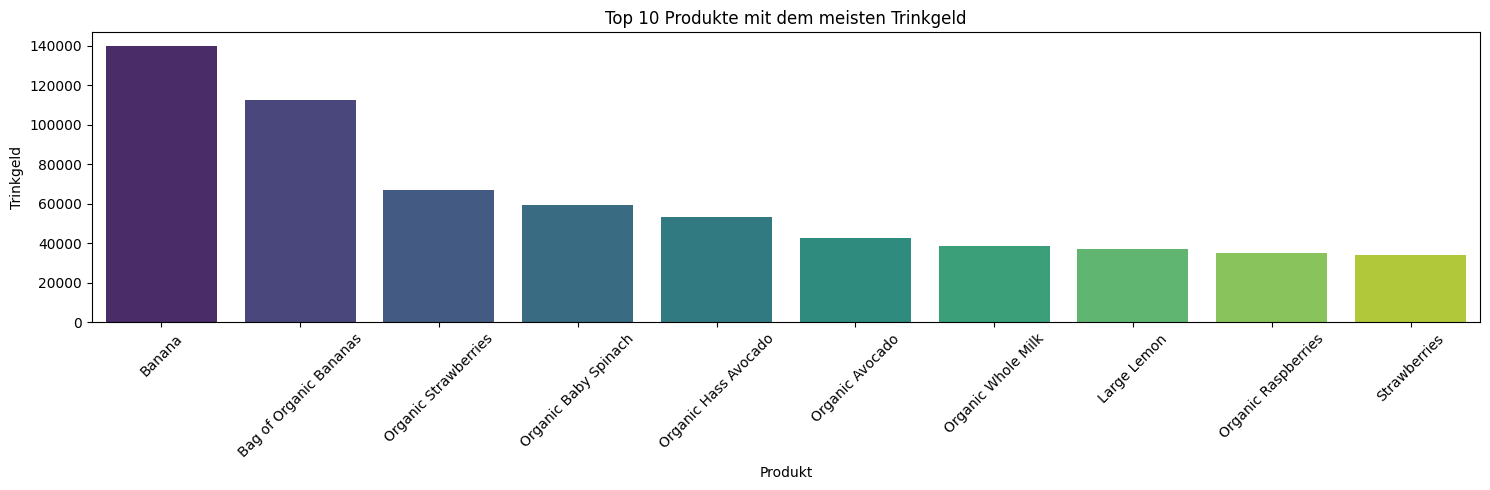

In [8]:
n = 10
plt.figure(figsize=(15, 5))
sns.barplot(x=product_tips_sorted["product_name"].head(n), y=product_tips_sorted["tip"].head(n), palette="viridis")
plt.xlabel("Produkt")
plt.ylabel("Trinkgeld")
plt.title(f"Top {n} Produkte mit dem meisten Trinkgeld")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Die Grafik zeigt die Top 10 Produkte an welche Trinkgelder bekommen.
Daraus wird sichtbar, dass am meisten Trinkgeld gegeben wird mit Produkten mit Banane, bei 260k Bestellungen waren Bananen oder Organische Bananen enthalten und bei denen wurde Trinkgeld gegeben. Bei 1/4 aller Bestellungen wo Trinkgeld gegeben wurde, waren Bananen ewnthalten, somit sind Kunden die diese kaufen bereiter Trinkgeld zu geben

## Trinkgeld-Verhalten nach Produktkategorie
---
Ein Balkendiagramm zeigt, ob bestimmte Produktkategorien eher zu Trinkgeldzahlungen führen, was Rückschlüsse auf den Wert der gekauften Waren zulässt

In [9]:
# Trinkgeld-Verhalten nach Produktkategorie
tip_by_department = full_df.groupby(['department', 'tip']).size().reset_index(name='count')
tip_by_department['tip'] = tip_by_department['tip'].map({True: "Mit Trinkgeld", False: "Ohne Trinkgeld"})

# Visualisierung: Verteilung von Bestellungen mit und ohne Trinkgeld nach Produktkategorie
fig = px.bar(
    tip_by_department, 
    x='department', 
    y='count', 
    color='tip', 
    title="Verteilung von Bestellungen mit/ohne Trinkgeld nach Produktkategorie",
    labels={'count': 'Anzahl der Bestellungen', 'department': 'Produktkategorie'},
    barmode='group'
)
fig.show()

Aus dem Balkendiagramm können wir erkennen, dass bei fast allen Produktkategorien die meisten Bestellungen ohne Trinkgeld sind. Es gibt manche Kategorien wie "Dairy Eggs" und "Meat Seafood", wo die Verteilung fast gleich ist. Bei "Alcohol" haben wir sogar mehr Bestellungen wo Trinkgeld gegeben wird als welche ohne

## Trinkgeld nach Department Größe
---
Wir schauen uns hier einmal kurz in welchen Departments wie viele Orders mit Trinkgeld vorhanden sind und zusätzlich schauen wir uns auch noch die Anzahl an Produkten an die in einem Department vorhanden sind.

In [10]:
# 1. Summiere die Tipps pro Department
tips_per_department = orders_with_tips.groupby("department")["tip"].sum()

# 2. Zähle die Anzahl der Produkte pro Department
products_per_department = df_master.groupby("department")["product_id"].nunique()

# 3. Kombiniere beide Ergebnisse in einen DataFrame
department_summary = pd.DataFrame({
    "total_amount_of_tips": tips_per_department,
    "product_count": products_per_department
}).sort_values(by=["total_amount_of_tips", "product_count"], ascending=[False, False])

# Zeige die Ergebnisse
department_summary

,total_amount_of_tips,product_count
department,,
produce,2330380,1678
dairy eggs,1383079,3425
snacks,632036,6209
beverages,538026,4320
frozen,402988,3979
pantry,374659,5323
bakery,238201,1510
deli,231456,1313
canned goods,209170,2074


Wir können an der Tabelle erkennen, dass man nicht unbedingt die meisten Produkte haben muss als Department, um die meisten Trinkgelder zu bekommen. Das Department Produce hat die meist gegebenen Trinkgelder, aber hat nicht die meisten Produkte.

Dies trifft aber nicht auf alle Departmenents zu, man kann jetzt nicht ein Departement eröffnen mit nur einem Produkt, dies würde auch nicht dementsprechened mehr Trinkgeld bekommen, als Beispiel das Department Bulk, es hat am wenigsten Produkte und ist zweitletzter im Ranking der Tringeldvergabe.

## Tendez der Kunden, Trinkgeld zu geben, nach Warenkorbgröße
---
Eine Histogramm-Analyse untersucht, ob größere Bestellungen eher Trinkgeldzahlungen begünstigen.

In [11]:
# Anzahl der Produkte in Bestellungen
full_df['order_size'] = full_df.groupby('order_id')['product_id'].transform('count')
tip_by_order_size = full_df.groupby(['order_size', 'tip']).size().reset_index(name='count')
tip_by_order_size['tip'] = tip_by_order_size['tip'].map({True: "Ohne Trinkgeld", False: "Mit Trinkgeld"})

# Visualisierung: Trinkgeldrate nach Anzahl der Produkte im Warenkorb
fig = px.histogram(
    tip_by_order_size, 
    x='order_size', 
    y='count', 
    color='tip', 
    title="Trinkgeldrate nach Anzahl der Produkte im Warenkorb",
    labels={'order_size': 'Warenkorbgröße', 'count': 'Anzahl der Bestellungen'},
    barmode='overlay'
)
fig.show()

Das meiste Trinkgeld wir gegeben bei einer Warenkorbgröße zwsichen 10 und 20 Produkten, gefolgt von 1 bis 10 und 20 bis 30. Danach gibt es auch noch eine Trinkgeldvergabe, jedoch fehlt die geringer aus als bei Warenkorben unter 30.
Zum Teil ist auch geschuldet, dass seltener Warenkörbe gibt, die diese Größe erreichen. Das Verhältnis ändert sich aber, mit einer Tendenz zu einer geringeren Trinkgeldvergabe

## Belastung der Mitarbeiter über den Tag hinweg
---
Ein ausgewogenes Arbeitsaufkommen ist essenziell, um eine hohe Servicequalität zu gewährleisten und die Zufriedenheit der Mitarbeiter zu sichern. Dieses Kapitel untersucht die Verteilung der Arbeitsbelastung über den Tag hinweg, basierend auf Bestellvolumen, Lieferzeitfenstern und regionalen Anforderungen. Mit diesen Daten können wir Stoßzeiten identifizieren, Schichtpläne anpassen und gegebenenfalls zusätzliche Ressourcen bereitstellen. Ziel ist es, Überlastungen zu vermeiden und gleichzeitig eine effiziente Abwicklung der Lieferungen sicherzustellen.

In [12]:
# Anzahl der Bestellungen und Trinkgeldverteilung pro Stunde
order_and_tips_by_hour = full_df.groupby(['order_hour_of_day', 'tip']).size().reset_index(name='count')
order_and_tips_by_hour['tip'] = order_and_tips_by_hour['tip'].map({True: "Mit Trinkgeld", False: "Ohne Trinkgeld"})

# Visualisierung: Anzahl der Bestellungen und Trinkgeldverteilung nach Stunde des Tages
fig1 = px.line(
    order_and_tips_by_hour, 
    x='order_hour_of_day', 
    y='count', 
    color='tip', 
    title="Bestellungen und Trinkgeldverteilung nach Stunde des Tages",
    labels={'count': 'Anzahl der Bestellungen', 'order_hour_of_day': 'Stunde des Tages'}
)
fig1.show()

Ab 19:30 haben wir mehr Bestellungen mit Trinkgeld als ohne, die Anzahl an Bestellungen ist nicht so hoch wie am Rest des Tages. Die Kurve der Trinkgeldverteilung wird nach 0 Uhr gleich sein und ab 5 Uhr werden mehr Bestellungen ohne Trinkgeld getätigt als mit. Unsere Kunden sind bereiter am Abend Trinkgeld zu geben im Vergleich zu den Bestellungen ohne Trinkgeld. Dies ist wahrscheinlich drauf rückzuführen, dass die meisten ab 19:30 zu Hause im Feierabend sind und sich was schönes kaufen wollen und anderen Personen mit dem Trinkgeld eine Freude zu machen 

## Wochentagsanalyse der Bestellungen und Trinkgeldvergabe
---
Das Bestellaufkommen und die Trinkgeldvergabe können je nach Wochentag erheblich variieren. In diesem Kapitel analysieren wir die Muster von Bestellungen und Trinkgeldern im Wochenverlauf. Wir identifizieren Tage mit hoher Nachfrage sowie Unterschiede in der Trinkgeldhöhe, um die Planung von Zustellern und Marketingaktionen zu optimieren. 

Diese Analyse unterstützt die Disposition dabei, sowohl die Personaleinsatzplanung als auch die Verfügbarkeit von Ressourcen strategisch zu gestalten.

In [13]:
# Anzahl der Bestellungen und Trinkgeldverteilung pro Wochentag
order_and_tips_by_dow = full_df.groupby(['order_dow', 'tip']).size().reset_index(name='count')
order_and_tips_by_dow['tip'] = order_and_tips_by_dow['tip'].map({True: "Mit Trinkgeld", False: "Ohne Trinkgeld"})

# Visualisierung: Bestellungen und Trinkgeldverteilung nach Wochentag
fig2 = px.bar(
    order_and_tips_by_dow, 
    x='order_dow', 
    y='count', 
    color='tip', 
    title="Bestellungen und Trinkgeldverteilung nach Wochentag",
    labels={'count': 'Anzahl der Bestellungen', 'order_dow': 'Wochentag'},
    barmode='group'
)
fig2.show()

Das Bestellvolumen am Samstag und am Sonntag ist am höchsten und zusätzlich kommt noch, dass da auch die meisten Bestellungen mit Trinkgeld gemacht werden. Das Bestellvolumen zwischen Trinkgeld und kein Trinkgeld ist auch relativ ähnlich. Unter der Woche sieht es anders aus, die meisten Bestellungen sind ohne Trinkgeld und im Schnitt gibt es 500k Bestellungen für ohne Trinkgeld mehr als mit mit. 

## Bestellungen mit und ohne Trinkgeld nach Wochentag und Uhrzeit
---
Mithilfe einer Heatmap ist man in der Lage, Spitzenzeiten zu erkennen, in denen Trinkgeld gegeben oder nicht gegeben wird und identifizieren potenziell wichtige Zeiträume

In [14]:
# Wochentag und Stunde des Trinkgelds
tip_by_dow_hour = full_df.groupby(['order_dow', 'order_hour_of_day', 'tip']).size().reset_index(name='count')
tip_by_dow_hour['tip'] = tip_by_dow_hour['tip'].map({True: "Mit Trinkgeld", False: "Ohne Trinkgeld"})

# Visualisierung: Bestellungen mit und ohne Trinkgeld nach Wochentag und Uhrzeit
fig = px.density_heatmap(
    tip_by_dow_hour, 
    x='order_hour_of_day', 
    y='order_dow', 
    z='count', 
    facet_col='tip', 
    color_continuous_scale="Viridis", 
    title="Bestellungen mit/ohne Trinkgeld nach Stunde und Wochentag"
)
fig.show()

In den beiden Heatmaps können wir das Kurvendiagramm "Bestellungen und Trinkgeldverteilung nach Stunde des Tages" und das Balkendiagramm "Bestellungen und Trinkgeldverteilung nach Wochentag" gut wiedererkennen. Wir erkennen aber noch eine zusätzliche Informationen für Bestellungen mit Trinkgeld, die meisten Bestellungen dafür passieren zwischen 10 und 15 Uhr am Samstag und Sonntag.

## Durchschnittliche Trinkgeldrate nach Stunde und Wochentag
---
Ein Liniendiagramm, wann die Kunden am ehesten Trinkgeld geben

In [15]:
# Statistische Untersuchung: Differenzen bei Trinkgeld nach Uhrzeit und Wochentag
# Durchschnittliche Trinkgeldrate pro Stunde und Wochentag
tip_rate_by_dow_hour = full_df.groupby(['order_dow', 'order_hour_of_day'])['tip'].mean().reset_index()
tip_rate_by_dow_hour.columns = ['Wochentag', 'Stunde', 'Trinkgeldrate']

# Visualisierung: Durchschnittliche Trinkgeldrate nach Stunde und Wochentag
fig = px.line(
    tip_rate_by_dow_hour, 
    x='Stunde', 
    y='Trinkgeldrate', 
    color='Wochentag', 
    title="Durchschnittliche Trinkgeldrate nach Stunde und Wochentag"
)
fig.show()

# Handlungsempfehlungen
---

Um zu vermeiden, dass manche Mitarbeiter regelmäßig mehr Trinkgeld bekommen als andere, könnte man eine gemeinsame Trinkgeldkasse einführen, das gesamte gesammelte Trinkgeld über den Tag bzw die Woche wird zusammengelegt und unter den Mitarbeiter gleich verteilt. 
Eine andere Möglichkeit wäre die Mitarbeiter in Schichtenarbeit arbeiten zu lassen, somit wird jeder Mitarbeiter immer an einer anderen Position arbeiten und an einem Tag in einer Abteilung wo er mehr Trinkgeld bekommt und an einem anderen weniger.